# Whole system assay Prx cycle

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Writes model of the Prx cycle **without decamers** (filename: "PRDX2_sys.psc")

Writes model of the Prx cycle **with decamers** (filename: "HRP\_PRDX2\_decfull.psc") by adding decamer reactions to the above model 

Performs simulations with the above models

**Requirements:**

Linux OS (for file input/output)

Python libraries (see **Imports** below)

Prx parameters (filename:"fitted_koff_kon_PRDX1_params.csv")

Prx decamer reactions (filename: "Prx decamer reactions - no hyperoxidation.txt")

##### Imports

In [1]:
import os
curdir = os.getcwd()
import copy

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.linear_model import LinearRegression

import pysces

os.chdir(curdir)

Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.24.3) with SciPy (1.10.1)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/jr/Pysces/psc
pysces.output_dir = /home/jr/Pysces


***********************************************************************
* Welcome to PySCeS (1.1.0) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2023  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with: doi

###### Save directories

In [2]:
prev_dir = "/".join(curdir.split("/")[:-1])
mod_dir = f"{prev_dir}/models"
par_dir = f"{prev_dir}/params"
fig_dir = f"{curdir}/Figures"

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    try:
        if not os.path.exists(f".{directory}"):
            os.mkdir(file_path)
    except OSError:
        pass
    
ensure_dir(mod_dir)
ensure_dir(par_dir)
ensure_dir(fig_dir)

###### Matplotlib stuff

In [4]:
%matplotlib inline

mpl_width = 4.5
mpl_height = 3.5
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"


In [5]:
WSA_no_dec_marker = "^"
WSA_dec_marker = "s"
# WSA_dec_dil = "o"
mpl_marker_size = 6

In [6]:
color_wheel = ["tab:blue","tab:green","tab:red","tab:cyan","tab:purple"]

##### fitted params

In [7]:
fitted_dim_dec_rates_file = "fitted_koff_kon_PRDX1_params.csv"
df_dim_dec_rates = pd.read_csv(f"{par_dir}/{fitted_dim_dec_rates_file}")
df_dim_dec_rates.set_index("Parameter",inplace=True)

In [8]:
def update_params_BenfeitasModels(mod,params,hyp=False):
    
    # Dimer-decamer transition params
    mod.exponent = 5
    mod.k_Prx_asso = params.loc["kon"][0]
    mod.k_Prx_dec_disasso = params.loc["koff"][0]
    
    ## Prx oxidation params
    mod.k_Prx_sulfe_SH_dec = mod.kprx
    mod.k_Prx_sulfe_SOH_dec = mod.kprx
    mod.k_Prx_disulf_form_SH_dec = mod.kcond
    mod.k_Prx_disulf_form_SOH_dec = mod.kcond
    mod.k_Prx_disso_SH_dec = 10000 # Arbitrary 
    mod.k_Prx_disso_SOH_dec = 10000 # Arbitrary
    
    if hyp == True:
        mod.k_Prx_sulfe_SOOH_dec = mod.kprx
        mod.k_Prx_sulfi_SOOH_dec = mod.ksulf
        mod.k_Prx_disulf_form_SOOH_dec = mod.kcond
        mod.k_Prx_srx_SOOH_dec = mod.ksrx 
        mod.k_Prx_disso_SOOH_dec = 10000 # Arbitrary
        
    # Adust dimer sulfenilation to be 100 slower than decamer
    mod.kprx = mod.kprx/100
#     mod.two_times_kprx = mod.two_times_kprx/100
    
    return mod


## PRDX2 system models

### Prx cycle no decamer

In [9]:
Prx_cycle = """

Function: TrxR, VMaxTrxR , KMNADPHTrxR , KMTrxSOH, NADPH, TrxSOH  {
VMaxTrxR*NADPH*TrxSOH/(TrxSOH*NADPH+KMNADPHTrxR*TrxSOH+NADPH*KMTrxSOH)}

### Reactions (Flag for scripting)

# Oxidation reactions
Prx_R_R_ox:
    SH_SH + H2O2 > SH_SOH
    2*kprx*SH_SH*H2O2

Prx_R_S_ox:
    SH_SS + H2O2 > SOH_SS
    kprx*SH_SS*H2O2

Prx_R_O_ox:
    SH_SOH + H2O2 > SOH_SOH
    kprx*SH_SOH*H2O2

Prx_R_O2_ox:
    SH_SO2H + H2O2 > SOH_SO2H
    kprx*SH_SO2H*H2O2

# Over-oxidation reactions
Prx_O_O_oox:
    SOH_SOH + H2O2 > SOH_SO2H
    2*ksulf*SOH_SOH*H2O2

Prx_O_S_oox:
    SOH_SS + H2O2 > SS_SO2H
    ksulf*SOH_SS*H2O2

Prx_R_O_oox:
    SH_SOH + H2O2 > SH_SO2H
    ksulf*SH_SOH*H2O2

Prx_O_O2_oox:
    SOH_SO2H + H2O2 > SO2H_SO2H
    ksulf*SOH_SO2H*H2O2

# Disulphide bridge formation
Prx_R_O_disulf_form:
    SH_SOH > SH_SS
    kcond*SH_SOH

Prx_O_O_disulf_form:
    SOH_SOH > SOH_SS
    2*kcond*SOH_SOH

Prx_O_S_disulf_form:
    SOH_SS > SS_SS
    kcond*SOH_SS

Prx_O_O2_disulf_form:
    SOH_SO2H > SS_SO2H
    kcond*SOH_SO2H

# Disulphide bridge reduction via Thioredoxin
Prx_R_S_red_TrxSH:
    SH_SS + TrxSH > SH_SH + TrxSOH
    kred*SH_SS*TrxSH

Prx_O_S_red_TrxSH:
    SOH_SS + TrxSH > SH_SOH + TrxSOH
    kred*SOH_SS*TrxSH

Prx_S_S_red_TrxSH:
    SS_SS + TrxSH > SH_SS + TrxSOH
    2*kred*SS_SS*TrxSH

Prx_S_O2_red_TrxSH:
    SS_SO2H + TrxSH > SH_SO2H + TrxSOH
    kred*SS_SO2H*TrxSH

# Trx regeneration
Trx_red1:
    TrxSOH + NADPH > NADP + TrxSH
    TrxR(VMaxTrxR,KMNADPHTrxR,KMTrxSOH,NADPH,TrxSOH)

H2O2_production:
    $pool > H2O2
    0.0

### Parameters (Flag for scripting)
kprx = 100 # μM/s
ksulf = 0.012 
kcond = 1.7
kred  = 0.21

VMaxTrxR = 10.0
KMNADPHTrxR = 6.0
KMTrxSOH = 1.83

### Species (Flag for scripting)
H2O2 = 4.0 # μM

SH_SH = 10.0
SH_SOH = 0.0
SH_SS = 0.0
SH_SO2H = 0.0
SOH_SOH = 0.0
SOH_SS = 0.0
SOH_SO2H = 0.0
SS_SS = 0.0
SS_SO2H = 0.0
SO2H_SO2H = 0.0

TrxSH = 5.0
TrxSOH = 0.0

NADPH = 5.0
NADP = 0.0

### References (Flag for scripting)

### End (Flag for scripting)
"""

In [10]:
# Write model .psc file
with open(f'{mod_dir}/PRDX2_sys.psc', 'w') as f:
    f.write(Prx_cycle)

#### Test model

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
CVODE time for 21 points: 0.017332792282104492


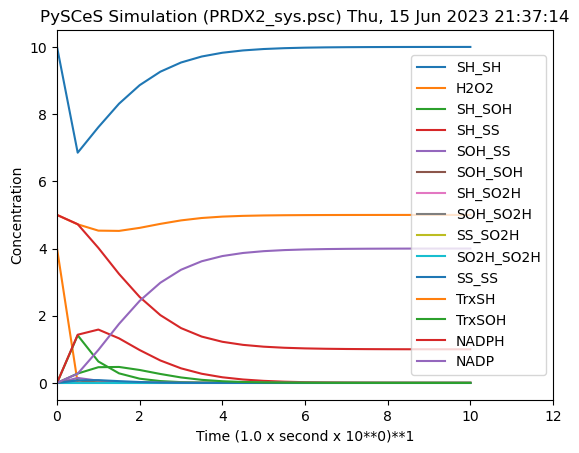

In [11]:
mod_Prx_cycle_no_dec = pysces.model("PRDX2_sys.psc", dir=mod_dir)
mod_Prx_cycle_no_dec.mode_integrator = 'CVODE'
mod_Prx_cycle_no_dec.doSimPlot()

### Prx cycle with decamer

In [13]:
orig_model_name = "PRDX2_sys"
decamer_reactions = "Prx decamer reactions - no hyperoxidation"
new_model_name = "PRDX2_sys_decfull"

In [14]:
written_species = list()
written_parameters = list()

omf =  open(f"{mod_dir}/{orig_model_name}.psc", "r")
omf_line = next(omf)
drf = open(f"{mod_dir}/{decamer_reactions}.txt", "r")
drf_line = next(drf)
drf_line = next(drf)

with open(f"{mod_dir}/{new_model_name}.psc", "w") as outf:
    orig_reactions_complete = False
    dec_reactions_complete = False
    orig_parameters_complete = False
    dec_parameters_complete = False
    orig_species_complete = False
    dec_species_complete = False
    orig_references_complete = False
    
    # Write dimer reactions
    while orig_reactions_complete == False:
        print(f"Write dimer reactions")
        if omf_line[0:14] == "### Parameters":
            orig_reactions_complete = True
            outf.write("## Decamer reactions\n")
            omf_line = next(omf)
        elif omf_line[0] == "#":
            omf_line = next(omf)
        else:
            outf.write(omf_line)
            omf_line = next(omf)
            
    # Write decamer reactions  
    while orig_reactions_complete == True and dec_reactions_complete == False:
        print(f"Write decamer reactions")
        if drf_line[0:14] == "### Parameters":
            dec_reactions_complete = True
            outf.write("### Parameters\n")
            outf.write("## Dimer parameters\n")
            drf_line = next(drf)
        else:
            outf.write(drf_line)
            drf_line = next(drf)
            
    # Write dimer parameters
    while dec_reactions_complete == True and orig_parameters_complete == False:
        print(f"Write dimer parameters")
        split_line = omf_line.split()
        if omf_line[0:11] == "### Species":
            orig_parameters_complete = True
            outf.write("## Decamer parameters\n")
            omf_line = next(omf)
        else:
            outf.write(omf_line)
            omf_line = next(omf)
            if len(split_line) > 0:
                written_parameters.append(split_line[0])

    # Write decamer parameters       
    while orig_parameters_complete == True and dec_parameters_complete == False:
        print(f"Write decamer parameters")
        split_line = drf_line.split()
        if drf_line[0:11] == "### Species":
            dec_parameters_complete = True
            outf.write("### Species\n")
            outf.write("## Dimer Species\n")
            drf_line = next(drf)
        elif len(split_line) > 0 and split_line[0] != "#":
            if split_line[0] not in written_parameters: # Nest like this so the code won't break when split_line is empty
                written_parameters.append(split_line[0])
                outf.write(drf_line)
                drf_line = next(drf)
            else:
                drf_line = next(drf)
        else:
            outf.write(drf_line)
            drf_line = next(drf)
            
    # Write dimer species
    while dec_parameters_complete == True and orig_species_complete == False:
        print(f"Write dimer species")
        split_line = omf_line.split()
        if omf_line[0:14] == "### References":
            orig_species_complete = True
            outf.write("## Decamer Species\n")
            omf_line = next(omf)
        elif len(split_line) > 0 and split_line[0] != "#": # Lines with # and ending in ":" causes issues
            written_species.append(split_line[0])
            outf.write(f"{split_line[0]} = {split_line[2]} \n")
            omf_line = next(omf)
        else:
            outf.write(omf_line)
            omf_line = next(omf)
            
    # Write decamer species
    while orig_species_complete == True and dec_species_complete == False:
        print(f"Write decamer species")
        split_line = drf_line.split()
        if drf_line[0:7] == "### End":
            dec_species_complete = True
            outf.write("### References\n")
            drf_line = next(drf)
        elif len(split_line) > 0:
            if split_line[0] not in written_species:
                written_species.append(split_line[0])
                outf.write(f"{split_line[0]} = {split_line[2]} \n")
                drf_line = next(drf)
            else:
                outf.write(drf_line)
                drf_line = next(drf)
        else:
            outf.write(drf_line)
            drf_line = next(drf)

    # Write the rest of orig file
    while dec_species_complete == True and orig_references_complete == False:
        print(f"Write references")
        if omf_line[0:7] == "### End":
            orig_references_complete = True
            outf.write("### End\n")
        else:
            outf.write(omf_line)
            omf_line = next(omf)
drf.close()
omf.close()

Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dimer reactions
Write dime

#### Test model

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . . . . . . . . . . . .  done.
 
CVODE time for 21 points: 0.3463327884674072


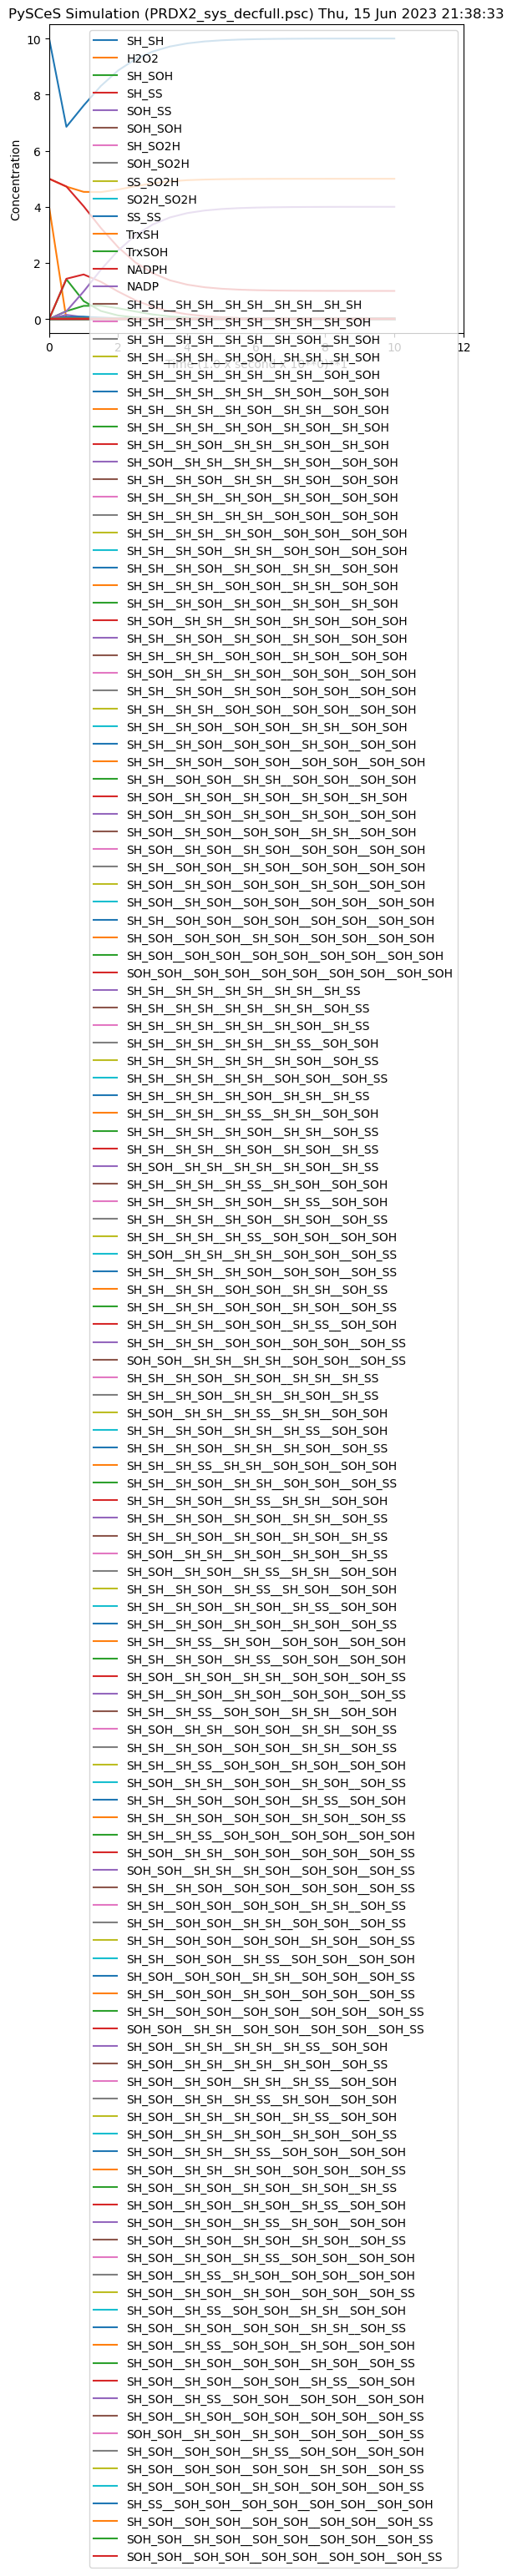

In [15]:
mod_Prx_cycle_with_dec = pysces.model("PRDX2_sys_decfull.psc", dir=mod_dir)
mod_Prx_cycle_with_dec.mode_integrator = 'CVODE'
mod_Prx_cycle_with_dec.doSimPlot()

## NADPH assays

In [16]:
def whole_system_assay(mod,
                       vary_range,
                       vary="H2O2_init",
                       end_time=15,
                       points=1000):
    
    wsa_results = list()
    
    for count,vary_species_init in enumerate(vary_range):
        
        # Copy model
        mod.__settings__["cvode_access_solver"] = False
        mod_copy = copy.deepcopy(mod)
        
        # Adjust model
        vary_orig = getattr(mod_copy,vary)
        setattr(mod_copy,vary,vary_species_init)
        
        # Get equilibrium
        H2O2_orig = getattr(mod_copy,"H2O2_init")
        setattr(mod_copy,"H2O2_init",0.0)
        mod_copy.doSim(end=1000000,points=2)
        
        # Set assay concentrations
        for species in mod_copy.species:
            setattr(mod_copy, f"{species}_init",mod_copy.sim[species][-1])
        setattr(mod_copy,"H2O2_init",H2O2_orig)

        # Simulate
        mod_copy.sim_end = end_time
        mod_copy.sim_points = points
        mod_copy.Simulate()

        # Grab data
        wsa_results.append((mod_copy.sim["Time"],mod_copy.sim["NADPH"]))
        
        # Restore model
        setattr(mod_copy,vary,vary_orig)
        
    wsa_results = np.array(wsa_results)

    return wsa_results

def fit_initial_rates(data,vary_range,start_point,end_point):
    
    initial_rates = list(map(lambda data_trace: get_initial_rate(data_trace,start_point,end_point,), data))
    
    initial_rate_data = np.array((vary_range,initial_rates)).transpose()
    
    return initial_rate_data

def get_initial_rate(trace_data,start_point,end_point):
    x_initial = trace_data[0][start_point:end_point].reshape(-1,1)
    y_initial = trace_data[1][start_point:end_point].reshape(-1,1)
    model = LinearRegression().fit(x_initial, y_initial)
    r_sq = model.score(x_initial, y_initial)
    if r_sq < 0.95:
        print(f"WARNING, non-linear data range:\n r_sq = {r_sq:.4}")
    return model.coef_[0][0]


### Parameter set 1

#### Vary H2O2

In [17]:
# Load models

# Prx cycle with decamers
mod_Prx_cycle_no_dec_p1 = pysces.model("PRDX2_sys.psc", dir=mod_dir)
mod_Prx_cycle_no_dec_p1.mode_integrator = 'CVODE'

# Prx cycle with decamers
mod_Prx_cycle_with_dec_p1 = pysces.model("PRDX2_sys_decfull.psc", dir=mod_dir)
mod_Prx_cycle_with_dec_p1.mode_integrator = 'CVODE'
mod_Prx_cycle_with_dec_p1 = update_params_BenfeitasModels(mod_Prx_cycle_with_dec_p1,df_dim_dec_rates)

# Set assay conditions
exp_Prx = 5
exp_Trx = 5
kcatTRR = 10
exp_TRR = 5
exp_H2O2 = 5
exp_NADPH = 150 # 5

# Adjust Prx cycle no decamer
setattr(mod_Prx_cycle_no_dec_p1, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_no_dec_p1, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_no_dec_p1, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_no_dec_p1, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_no_dec_p1, "NADPH_init", exp_NADPH)

# Adjust Prx cycle with decamer
setattr(mod_Prx_cycle_with_dec_p1, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_with_dec_p1, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_with_dec_p1, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_with_dec_p1, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_with_dec_p1, "NADPH_init", exp_NADPH)


Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . . . . . . . . . . . .  done.
 


In [18]:
# Do simulation
vary_range = np.linspace(1,20,5)
vary_species = "H2O2_init"
wsa_no_dec_p1_vh = whole_system_assay(mod_Prx_cycle_no_dec_p1,vary_range,vary_species)
wsa_with_dec_p1_vh = whole_system_assay(mod_Prx_cycle_with_dec_p1,vary_range,vary_species)

CVODE time for 2 points: 0.0009672641754150391
CVODE time for 1000 points: 0.054833412170410156
CVODE time for 2 points: 0.0007870197296142578
CVODE time for 1000 points: 0.05005669593811035
CVODE time for 2 points: 0.0005984306335449219
CVODE time for 1000 points: 0.05718684196472168
CVODE time for 2 points: 0.0006377696990966797
CVODE time for 1000 points: 0.06577253341674805
CVODE time for 2 points: 0.0007541179656982422
CVODE time for 1000 points: 0.06354856491088867
CVODE time for 2 points: 0.3786122798919678
CVODE time for 1000 points: 0.7186899185180664
CVODE time for 2 points: 0.3706376552581787
CVODE time for 1000 points: 0.9725773334503174
CVODE time for 2 points: 0.3697197437286377
CVODE time for 1000 points: 1.1809003353118896
CVODE time for 2 points: 0.3865015506744385
CVODE time for 1000 points: 1.1793296337127686
CVODE time for 2 points: 0.3900573253631592
CVODE time for 1000 points: 1.439141035079956


/tmp/ipykernel_1256541/257840606.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


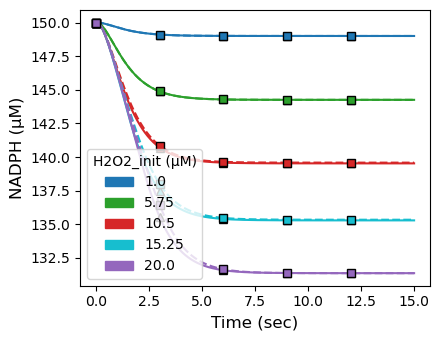

In [19]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

handle_list= []

for count,result in enumerate(wsa_no_dec_p1_vh):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",               
               marker=WSA_no_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k') 
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label=f"{vary_range[count]}")
    handle_list.append(handle)

for count,result in enumerate(wsa_with_dec_p1_vh):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",             
               marker=WSA_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k',
               linestyle="--")#,label = f"{vary_species} = {vary_range[count]} {mu}M") 
    
# axarr.set_title(f"Varying {vary_species}")
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"NADPH ({mu}M)",fontsize=mpl_ylabel_fontsize)

axarr.legend(handles=handle_list,title=f"{vary_species} ({mu}M)")
f.tight_layout()
f.show()
# f.savefig(f"{curdir}/Figures/Absorbance_traces.pdf",dpi= mpl_dpi)

#### Vary Prx

In [20]:
# Load models

# Prx cycle with decamers
mod_Prx_cycle_no_dec_p1 = pysces.model("PRDX2_sys.psc", dir=mod_dir)
mod_Prx_cycle_no_dec_p1.mode_integrator = 'CVODE'

# Prx cycle with decamers
mod_Prx_cycle_with_dec_p1 = pysces.model("PRDX2_sys_decfull.psc", dir=mod_dir)
mod_Prx_cycle_with_dec_p1.mode_integrator = 'CVODE'
mod_Prx_cycle_with_dec_p1 = update_params_BenfeitasModels(mod_Prx_cycle_with_dec_p1,df_dim_dec_rates)

# Set assay conditions
exp_Prx = 5
exp_Trx = 5
kcatTRR = 10
exp_TRR = 5
exp_H2O2 = 5
exp_NADPH = 150 # 5

# Adjust Prx cycle no decamer
setattr(mod_Prx_cycle_no_dec_p1, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_no_dec_p1, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_no_dec_p1, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_no_dec_p1, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_no_dec_p1, "NADPH_init", exp_NADPH)

# Adjust Prx cycle with decamer
setattr(mod_Prx_cycle_with_dec_p1, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_with_dec_p1, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_with_dec_p1, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_with_dec_p1, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_with_dec_p1, "NADPH_init", exp_NADPH)


Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . . . . . . . . . . . .  done.
 


In [21]:
# Do simulation
# vary_range = np.linspace(1,5,5)
vary_range = np.array([0.1,0.5,2])
vary_species = "SH_SH_init"
wsa_no_dec_p1_vp = whole_system_assay(mod_Prx_cycle_no_dec_p1,vary_range,vary_species)
wsa_with_dec_p1_vp = whole_system_assay(mod_Prx_cycle_with_dec_p1,vary_range,vary_species)

CVODE time for 2 points: 0.0013427734375
CVODE time for 1000 points: 0.04669976234436035
CVODE time for 2 points: 0.0008106231689453125
CVODE time for 1000 points: 0.05478239059448242
CVODE time for 2 points: 0.0006999969482421875
CVODE time for 1000 points: 0.05240797996520996
CVODE time for 2 points: 0.1301572322845459
CVODE time for 1000 points: 0.4576129913330078
CVODE time for 2 points: 0.16710805892944336
CVODE time for 1000 points: 0.921823263168335
CVODE time for 2 points: 0.24095511436462402
CVODE time for 1000 points: 1.086625576019287


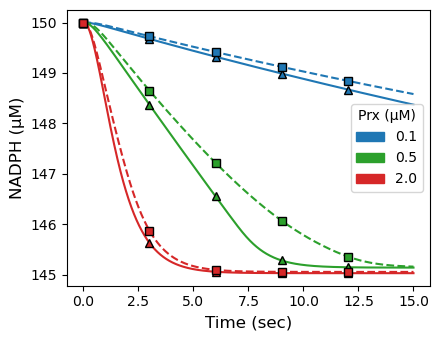

In [22]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

handle_list= []

for count,result in enumerate(wsa_no_dec_p1_vp):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",
               marker=WSA_no_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k') 
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label=f"{vary_range[count]}")
    handle_list.append(handle)
    
for count,result in enumerate(wsa_with_dec_p1_vp):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",
               marker=WSA_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k',
               linestyle="--")#,label = f"{vary_species} = {vary_range[count]} {mu}M") 
    
# axarr.set_title(f"Varying {vary_species}")
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"NADPH ({mu}M)",fontsize=mpl_ylabel_fontsize)

axarr.legend(handles=handle_list,title=f"Prx ({mu}M)")
f.tight_layout()
# f.show()
# f.savefig(f"{curdir}/Figures/Absorbance_traces.pdf",dpi= mpl_dpi)

### Parameter set 2: Melinda thesis fig 4.14 

#### Vary H2O2

In [23]:
# Load models

# Prx cycle with decamers
mod_Prx_cycle_no_dec_p2 = pysces.model("PRDX2_sys.psc", dir=mod_dir)
mod_Prx_cycle_no_dec_p2.mode_integrator = 'CVODE'

# Prx cycle with decamers
mod_Prx_cycle_with_dec_p2 = pysces.model("PRDX2_sys_decfull.psc", dir=mod_dir)
mod_Prx_cycle_with_dec_p2.mode_integrator = 'CVODE'
mod_Prx_cycle_with_dec_p2 = update_params_BenfeitasModels(mod_Prx_cycle_with_dec_p2,df_dim_dec_rates)

# Set assay conditions
exp_Prx = 0.05 # µM
exp_Trx = 10 # µM
kcatTRR = 10
exp_TRR = 0.5 # µM
exp_H2O2 = 5 # H2O2 0 to 10 µM
exp_NADPH = 150 # µM
# ammonium sulfate, 100 mM; EDTA, 1 mM; potassium phosphate, 25 mM 
# (pH 7)

# Adjust Prx cycle no decamer
setattr(mod_Prx_cycle_no_dec_p2, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_no_dec_p2, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_no_dec_p2, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_no_dec_p2, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_no_dec_p2, "NADPH_init", exp_NADPH)

# Adjust Prx cycle with decamer
setattr(mod_Prx_cycle_with_dec_p2, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_with_dec_p2, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_with_dec_p2, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_with_dec_p2, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_with_dec_p2, "NADPH_init", exp_NADPH)

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . . . . . . . . . . . .  done.
 


In [24]:
# Do simulation
vary_range = np.array([0.0,2.5,7.5,10.0])
vary_species = "H2O2_init"
wsa_no_dec_p2_vh = whole_system_assay(mod_Prx_cycle_no_dec_p2,vary_range,vary_species,end_time=600)
wsa_with_dec_p2_vh = whole_system_assay(mod_Prx_cycle_with_dec_p2,vary_range,vary_species,end_time=600)

CVODE time for 2 points: 0.0016582012176513672
CVODE time for 1000 points: 0.035768985748291016
CVODE time for 2 points: 0.0014412403106689453
CVODE time for 1000 points: 0.05502486228942871
CVODE time for 2 points: 0.00079345703125
CVODE time for 1000 points: 0.048777103424072266
CVODE time for 2 points: 0.0006854534149169922
CVODE time for 1000 points: 0.04718923568725586
CVODE time for 2 points: 0.08000802993774414
CVODE time for 1000 points: 0.23946619033813477
CVODE time for 2 points: 0.07627081871032715
CVODE time for 1000 points: 0.7416982650756836
CVODE time for 2 points: 0.07837486267089844
CVODE time for 1000 points: 0.5682156085968018
CVODE time for 2 points: 0.08409285545349121
CVODE time for 1000 points: 0.5138595104217529


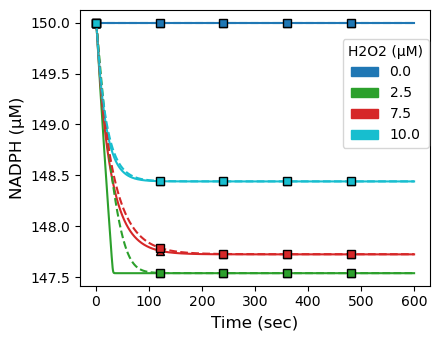

In [26]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width,h=mpl_height)

handle_list= []

for count,result in enumerate(wsa_no_dec_p2_vh):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",
               marker=WSA_no_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k') 
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label=f"{vary_range[count]}")
    handle_list.append(handle)
    
for count,result in enumerate(wsa_with_dec_p2_vh):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",
               linestyle="--",
               marker=WSA_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k')#,label = f"Prx = {vary_range[count]} {mu}M") 
    
# axarr.set_title(f"Varying {vary_species}")
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"NADPH ({mu}M)",fontsize=mpl_ylabel_fontsize)

title_species = vary_species.split("_")[0]
axarr.legend(handles=handle_list,title=f"{title_species} ({mu}M)",loc=(0.75,0.5))
f.tight_layout()
# f.show()
# f.savefig(f"{curdir}/Figures/wsa_Melindaf4-14_NADPH_v_Time_vary_H2O2.pdf",dpi= mpl_dpi)

#### Vary Prx

In [27]:
# Load models

# Prx cycle with decamers
mod_Prx_cycle_no_dec_p2 = pysces.model("PRDX2_sys.psc", dir=mod_dir)
mod_Prx_cycle_no_dec_p2.mode_integrator = 'CVODE'

# Prx cycle with decamers
mod_Prx_cycle_with_dec_p2 = pysces.model("PRDX2_sys_decfull.psc", dir=mod_dir)
mod_Prx_cycle_with_dec_p2.mode_integrator = 'CVODE'
mod_Prx_cycle_with_dec_p2 = update_params_BenfeitasModels(mod_Prx_cycle_with_dec_p2,df_dim_dec_rates)

# Set assay conditions
exp_Prx = 0.05 # µM
exp_Trx = 10 # µM
kcatTRR = 10
exp_TRR = 0.5 # µM
exp_H2O2 = 5 # H2O2 0 to 10 µM
exp_NADPH = 150 # µM
# ammonium sulfate, 100 mM; EDTA, 1 mM; potassium phosphate, 25 mM 
# (pH 7)

# Adjust Prx cycle no decamer
setattr(mod_Prx_cycle_no_dec_p2, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_no_dec_p2, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_no_dec_p2, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_no_dec_p2, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_no_dec_p2, "NADPH_init", exp_NADPH)

# Adjust Prx cycle with decamer
setattr(mod_Prx_cycle_with_dec_p2, "SH_SH_init", exp_Prx)
setattr(mod_Prx_cycle_with_dec_p2, "TrxSH_init", exp_Trx)
setattr(mod_Prx_cycle_with_dec_p2, "VMaxTrxR", exp_TRR*kcatTRR)
setattr(mod_Prx_cycle_with_dec_p2, "H2O2_init", exp_H2O2)
setattr(mod_Prx_cycle_with_dec_p2, "NADPH_init", exp_NADPH)

Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
Using model directory: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models
/home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc loading ..... 
Parsing file: /home/jr/Documents/papers/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . . . . . . . . . . . .  done.
 


In [28]:
# Do simulation
# vary_range = np.linspace(1,10,4)
vary_range = np.array([0.01,0.05,0.1])
vary_species = "SH_SH_init"
wsa_no_dec_p2_vp = whole_system_assay(mod_Prx_cycle_no_dec_p2,vary_range,vary_species,end_time=300)
wsa_with_dec_p2_vp = whole_system_assay(mod_Prx_cycle_with_dec_p2,vary_range,vary_species,end_time=300)

CVODE time for 2 points: 0.0014576911926269531
CVODE time for 1000 points: 0.04921102523803711
CVODE time for 2 points: 0.0007679462432861328
CVODE time for 1000 points: 0.05536079406738281
CVODE time for 2 points: 0.0006375312805175781
CVODE time for 1000 points: 0.05111527442932129
CVODE time for 2 points: 0.03614401817321777
CVODE time for 1000 points: 0.5626120567321777
CVODE time for 2 points: 0.0822303295135498
CVODE time for 1000 points: 0.7812314033508301
CVODE time for 2 points: 0.1282825469970703
CVODE time for 1000 points: 0.8483257293701172


/tmp/ipykernel_1256541/2427742375.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


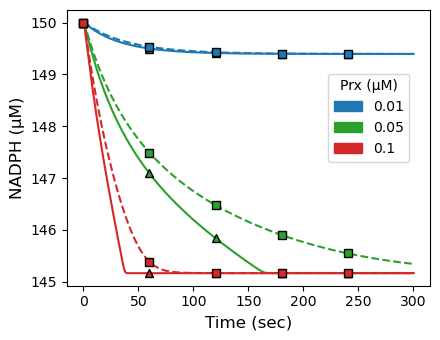

In [29]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

handle_list= []

for count,result in enumerate(wsa_no_dec_p2_vp):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",
               marker=WSA_no_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k')
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label=f"{vary_range[count]}")
    handle_list.append(handle)
    
for count,result in enumerate(wsa_with_dec_p2_vp):
    axarr.plot(result[0], 
               result[1], 
               f"{color_wheel[count]}",
               linestyle="--",
               marker=WSA_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k')#,label = f"{vary_species} = {vary_range[count]} {mu}M") 
    
# axarr.set_title(f"Varying {vary_species}")
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"NADPH ({mu}M)",fontsize=mpl_ylabel_fontsize)

title_species = "Prx"
axarr.legend(handles=handle_list,title=f"{title_species} ({mu}M)",loc=(0.72,0.45))
f.tight_layout()
f.show()
# f.savefig(f"{curdir}/Figures/wsa_NADPH_v_time_vary_Prx.pdf",dpi= mpl_dpi)

In [30]:
# Fit rate constant
start_point = 3
end_point = 10
wsa_no_dec_p2_vp_initial_rates = fit_initial_rates(wsa_no_dec_p2_vp,vary_range,start_point,end_point)
wsa_no_dec_p2_vp_fit = LinearRegression().fit(wsa_no_dec_p2_vp_initial_rates[:,0].reshape(-1,1), 
                                               np.abs(wsa_no_dec_p2_vp_initial_rates[:,1]).reshape(-1,1))

wsa_with_dec_p2_vp_initial_rates = fit_initial_rates(wsa_with_dec_p2_vp,vary_range,start_point,end_point)
wsa_with_dec_p2_vp_fit = LinearRegression().fit(wsa_with_dec_p2_vp_initial_rates[:,0].reshape(-1,1), 
                                               np.abs(wsa_with_dec_p2_vp_initial_rates[:,1]).reshape(-1,1))


/tmp/ipykernel_1256541/1360238213.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


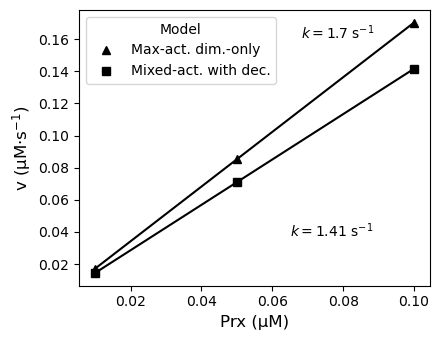

In [31]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

axarr.plot(wsa_no_dec_p2_vp_initial_rates[:,0],
           np.abs(wsa_no_dec_p2_vp_initial_rates[:,1]),
           color=f"k",
           label="Max-act. dim.-only",
           marker=WSA_no_dec_marker,
           markersize = mpl_marker_size,
           linestyle="None")
axarr.plot(vary_range, 
           wsa_no_dec_p2_vp_fit.predict(vary_range.reshape(-1,1)),
           f"k-")
axarr.text(0.068,0.16,f"$k={wsa_no_dec_p2_vp_fit.coef_[0][0]:.3}\ \mathrm{{s^{{-1}}}}$")
# axarr.canvas.mpl_connect('close_event', on_close)

axarr.plot(wsa_with_dec_p2_vp_initial_rates[:,0],
           np.abs(wsa_with_dec_p2_vp_initial_rates[:,1]),
           color=f"k",
           label=f"Mixed-act. with dec.",
           marker=WSA_dec_marker,
           markersize = mpl_marker_size,
          linestyle="None")
axarr.plot(vary_range, 
           wsa_with_dec_p2_vp_fit.predict(vary_range.reshape(-1,1)),
           f"k-")
axarr.text(0.065,0.037,f"$k={wsa_with_dec_p2_vp_fit.coef_[0][0]:.3}\ \mathrm{{s^{{-1}}}}$")

# axarr.set_title(f"Varying {vary_species}")
axarr.set_xlabel(f"Prx ({mu}M)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"v ({mu}M$\cdot \mathrm{{s^{{-1}}}}$)",fontsize=mpl_ylabel_fontsize)

# title_species = "Prx"
axarr.legend(title = f"Model")
f.tight_layout()
f.show()
# f.savefig(f"{curdir}/Figures/wsa_p2_Prx_v_rate.pdf",dpi= mpl_dpi)